<a href="https://colab.research.google.com/github/erl-j/surprise/blob/main/play_chords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
!mkdir artefacts

In [2]:
# download minGPT
!git clone https://github.com/karpathy/minGPT.git

# add minGPT to path
import os, sys
sys.path.append(os.path.join(os.path.dirname("minGPT"), "minGPT"))

Cloning into 'minGPT'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (175/175), 1.37 MiB | 10.09 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [3]:
# install missing libraries
!pip install pretty_midi==0.2.9 visual_midi==1.1.0 note-seq==0.0.2

     |████████████████████████████████| 5.6 MB 4.4 MB/s 
     |████████████████████████████████| 209 kB 45.3 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
     |████████████████████████████████| 3.5 MB 37.0 MB/s 
     |████████████████████████████████| 20.2 MB 1.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=7773c44808b956553227564145c8076f0be9311a9311107f74e721cc92237204
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [4]:
# minGPT imports
import random
import logging
from mingpt.utils import set_seed
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from torch.utils.data import Dataset
from mingpt.model import GPT, GPTConfig
from mingpt.trainer import Trainer, TrainerConfig
from mingpt.utils import sample
import glob
from tqdm import tqdm
import pretty_midi
import visual_midi
import note_seq
import json
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython

In [5]:
# make deterministic
SEED=42
set_seed(SEED)
random.seed(SEED)

# setup logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

# Synthesis utils

In [6]:
SAMPLE_RATE=44100

def note2hz(note):
  a = 440 #frequency of A (coomon value is 440Hz)
  return (a / 32) * (2 ** ((note - 9) / 12))

def synthesize_chords(chords):
  fade_duration=0.05
  chord_duration=1.0
  n_chord_samples=int(chord_duration*SAMPLE_RATE)
  fade_samples=int(fade_duration*SAMPLE_RATE)
  chord_audio=[]
  for c in chords:
    if c not in (BOS_TOKEN,EOS_TOKEN):
      audio=np.zeros((n_chord_samples))
      notes=symbol2notes[c]
      hzs=[note2hz(36+12*2+n) for n in notes]
      for hz in hzs:
        audio+=np.sin(np.linspace(0,2*np.pi*hz,n_chord_samples))
      audio[:fade_samples]=audio[:fade_samples]*np.linspace(0,1,fade_samples)
      audio[-fade_samples:]=audio[-fade_samples:]*np.linspace(1,0,fade_samples)
      chord_audio.append(audio)
  return np.concatenate(chord_audio)

def play_audio(array):
  IPython.display.display(IPython.display.Audio(array,rate=SAMPLE_RATE))


# Download lead sheet dataset

In [7]:
# download and unzip hooktheory lead sheets dataset (takes about a minute)
# the dataset originally comes from here: https://github.com/wayne391/lead-sheet-dataset

!wget https://kth.box.com/shared/static/t69zmdrc8p6ccchs4m152x7xoi7iqe5o.zip
!unzip -o -q t69zmdrc8p6ccchs4m152x7xoi7iqe5o.zip

--2021-11-25 09:23:41--  https://kth.box.com/shared/static/t69zmdrc8p6ccchs4m152x7xoi7iqe5o.zip
Resolving kth.box.com (kth.box.com)... 107.152.29.197
Connecting to kth.box.com (kth.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/t69zmdrc8p6ccchs4m152x7xoi7iqe5o.zip [following]
--2021-11-25 09:23:41--  https://kth.box.com/public/static/t69zmdrc8p6ccchs4m152x7xoi7iqe5o.zip
Reusing existing connection to kth.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://kth.app.box.com/public/static/t69zmdrc8p6ccchs4m152x7xoi7iqe5o.zip [following]
--2021-11-25 09:23:41--  https://kth.app.box.com/public/static/t69zmdrc8p6ccchs4m152x7xoi7iqe5o.zip
Resolving kth.app.box.com (kth.app.box.com)... 107.152.29.201
Connecting to kth.app.box.com (kth.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

In [8]:
fps=glob.glob("./event/**/*symbol_nokey.json",recursive=True)

# a mapping between chords symbols and notes, we use this to synthesize chords later on.
symbol2notes={}

songs=[]
for fp in tqdm(fps):
  with open(fp,"rb") as f:
    d=json.load(f)
    chord_objects=d["tracks"]["chord"]

    for co in chord_objects:
      if co is not None:
        symbol2notes[co["symbol"]]=co["composition"]

    songs.append([c["symbol"] for c in chord_objects if c is not None])


100%|██████████| 19876/19876 [00:05<00:00, 3865.78it/s]


# Define sequence dataset


In [9]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, block_size, tokens=None):

        # if list of tokens not provided, make list of tokens 
        if tokens is None:
          tokens = list(set([item for sequence in sequences for item in sequence]))
        self.tokens=tokens
        self.stoi = {t: i for i, t in enumerate(tokens)}
        self.itos = {i: t for i, t in enumerate(tokens)}
        self.block_size = block_size
        self.vocab_size = len(tokens)
        self.sequences = sequences


    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):

        chunk=self.sequences[idx]
            
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk ]
    
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

# Load dataset

19876
19634


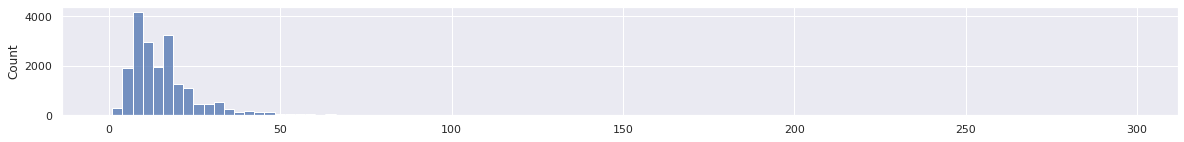

In [37]:
sequences=songs

print(len(sequences))

# remove empty sequences
sequences=[s for s in sequences  if len(s)>0]
print(len(sequences))

seq_lengths=[]
for s in sequences:
  seq_lengths.append(len(s))

sns.histplot(seq_lengths,bins=100)

BOS_TOKEN="<BOS>"
EOS_TOKEN="<EOS>"

# load midi and encode
BLOCK_SIZE = 32 # spatial extent of the  model for its context

def crop_and_pad(sequence,target_len):
  # add bos token
  sequence=[BOS_TOKEN]+sequence
  if len(sequence)>target_len:
    sequence=sequence[:target_len]
  # pad with eos token
  sequence=sequence+[EOS_TOKEN]*(target_len-len(sequence))
  return sequence

sequences=[crop_and_pad(s,BLOCK_SIZE) for s in sequences]

random.shuffle(sequences)
N_VAL=4000

tokens=SequenceDataset(sequences,BLOCK_SIZE).tokens

trn_ds=SequenceDataset(sequences[:-N_VAL],BLOCK_SIZE,tokens)
val_ds=SequenceDataset(sequences[-N_VAL:],BLOCK_SIZE,tokens)

In [ ]:
# precompute tonnetz distance between all chords.
# 

# Train



In [49]:
# layers are layers, n_heads : split the perceptive field, n_embd : embedding size
# tradformer has n_layer=16, n_head=4, n_embd=128 
mconf = GPTConfig(trn_ds.vocab_size, trn_ds.block_size,
                  n_layer=10, n_head=1, n_embd=128)
model = GPT(mconf)

CKPT_PATH="artefacts/model"

if os.path.exists(CKPT_PATH):
  print("loading checkpoint")
  model=torch.load(CKPT_PATH)
else:
  print("couldn't find checkpoint")

# initialize a trainer instance and kick off training
# fancy gpt schedule, look on github
tconf = TrainerConfig(max_epochs=40, batch_size=512, learning_rate=6e-4,num_workers=2)

trainer = Trainer(model, trn_ds, val_ds, tconf)
trainer.train()

11/25/2021 09:41:55 - INFO - mingpt.model -   number of parameters: 2.163968e+06


loading checkpoint


epoch 1 iter 30: train loss 1.16336. lr 6.000000e-04: 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]
11/25/2021 09:42:07 - INFO - mingpt.trainer -   test loss: 1.107928
epoch 2 iter 30: train loss 1.09376. lr 6.000000e-04: 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]
11/25/2021 09:42:19 - INFO - mingpt.trainer -   test loss: 1.093835
epoch 3 iter 30: train loss 1.15610. lr 6.000000e-04: 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]
11/25/2021 09:42:31 - INFO - mingpt.trainer -   test loss: 1.088618
epoch 4 iter 30: train loss 1.15647. lr 6.000000e-04: 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]
11/25/2021 09:42:42 - INFO - mingpt.trainer -   test loss: 1.089819
epoch 5 iter 30: train loss 1.00839. lr 6.000000e-04: 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]
11/25/2021 09:42:54 - INFO - mingpt.trainer -   test loss: 1.085736
epoch 6 iter 30: train loss 1.03115. lr 6.000000e-04: 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]
11/25/2021 09:43:06 - INFO - mingpt.trainer -   

KeyboardInterrupt: ignored

In [48]:
  torch.save(model, CKPT_PATH)

# Generate

In [13]:
# load an example midi file and take first 10 notes as context

context = [BOS_TOKEN,"C"]

x = torch.tensor([trn_ds.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(model, x, 10, temperature=1.0, sample=True, top_k=20)[0]
completion = [trn_ds.itos[int(i)] for i in y]

play_audio(synthesize_chords(completion))

# Surprise utils

In [73]:
def compute_pies(input):
  x = torch.tensor([trn_ds.stoi[s] for s in input], dtype=torch.long)[None,...].to(trainer.device)
  logits=model.forward(x)[0]
  token_dist=torch.softmax(logits,axis=-1).detach().cpu().numpy()
  x=x.detach().cpu().numpy()
  probabilities=[]
  entropies=[]
  for t in range(x.shape[1]-1):
    probabilities.append(token_dist[0,t,x[0,t+1]])
    entropies.append(-np.sum(np.log2(token_dist[0,t,:])*token_dist[0,t,:]))
  probability=np.array(probabilities)
  self_info=-np.log2(probability)
  entropy=np.array(entropies)
  surprise=self_info/entropy
  return probability,self_info,entropy,surprise

def plot_words(tokens,values,label):
  unique_tokens=[]
  token2count={}
  for t in tokens:
    if t not in token2count:
      token2count[t]=0
    unique_tokens.append(t+"_"+str(token2count[t]))
    token2count[t]+=1
  
  sns.set(rc={'figure.figsize':(20,2)})
  sns.color_palette("rocket")
  ax=sns.barplot(x=unique_tokens,y=values)
  ax.set_xticklabels(tokens)
  ax.set_title(label)
  ax.tick_params(labelsize=14)
  plt.show()
  
def surprise_sampling(context, completion_contour,use_self_info=False):
  input=context
  for c in completion_contour:
    x = torch.tensor([trn_ds.stoi[s] for s in input], dtype=torch.long)[None,...].to(trainer.device)
    logits=model.forward(x)[0]
    token_dist=torch.softmax(logits,axis=-1).detach().cpu().numpy()
    x=x.detach().cpu().numpy()
    last_token_probability=token_dist[0,-1,:]
    last_token_self_info=-np.log2(last_token_probability)
    last_token_entropy=-np.sum(np.log2(last_token_probability)*last_token_probability)
    last_token_surprise=last_token_self_info/last_token_entropy
    if use_self_info:
      new_token_idx = np.argmin(np.abs(c-last_token_self_info))
    else:
      new_token_idx = np.argmin(np.abs(c-last_token_surprise))
    input=input+[trn_ds.itos[int(new_token_idx)]]
  return input

# Generate from surprise contour

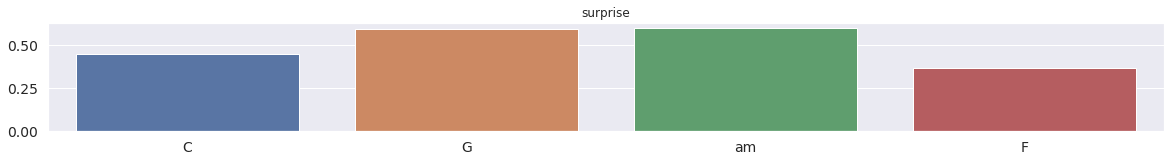

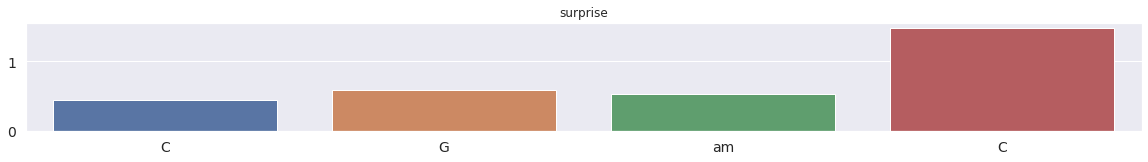

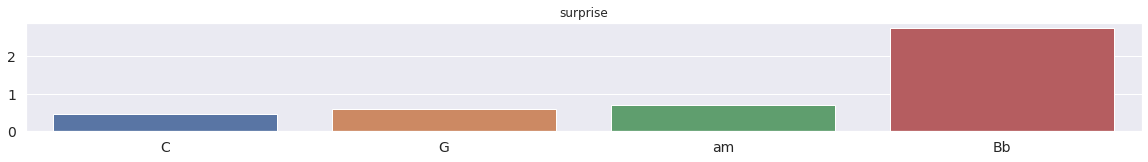

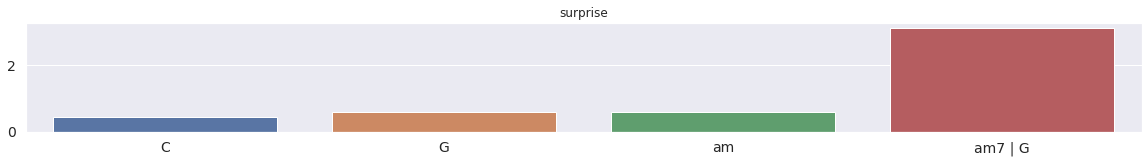

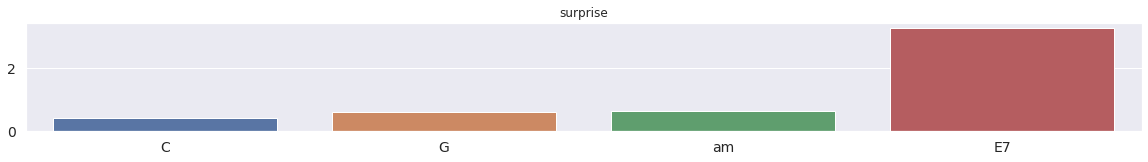

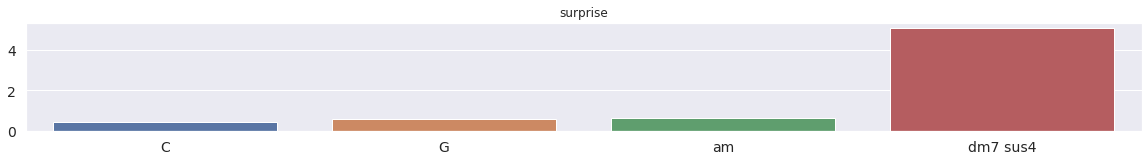

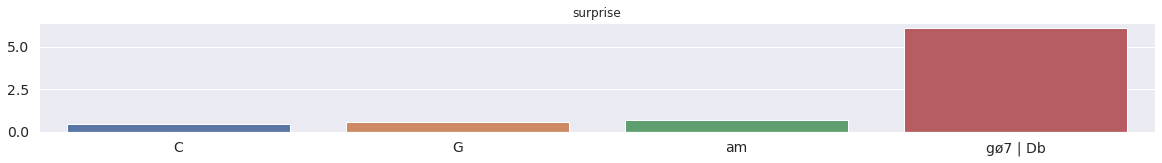

In [74]:
context=[BOS_TOKEN,"C","G","am"]

for last_chord_surprise in [0.00,1.0,2.0,3.0,4.0,5.0,6.0]:
  contour=[last_chord_surprise]
  output = surprise_sampling(context,contour)
  p,i,e,s=compute_pies(output)
  plot_words(output[1:],s,"surprise")

  play_audio(synthesize_chords(output))

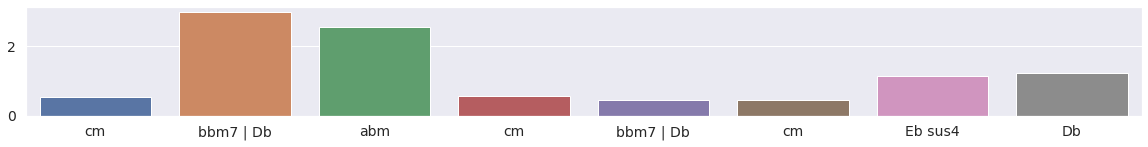

In [59]:
context=[BOS_TOKEN]

contour=[0.5,3.0,2.0,0.0,0.0,0.0,1.0,1.0]
output = surprise_sampling(context,contour)
p,i,e,s=compute_pies(output)
plot_words(output[1:],s)

play_audio(synthesize_chords(output))

# Analyze surprise contour

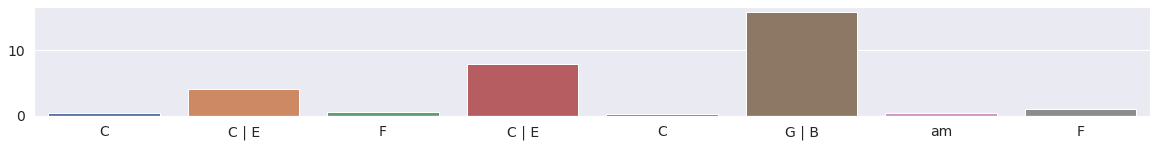

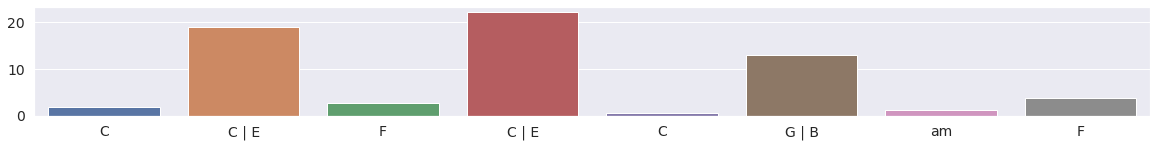

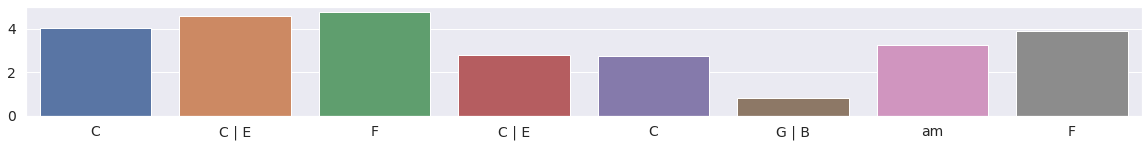

In [45]:
test_chords=sequences[27][:9]
p,i,e,s=compute_pies(test_chords)

plot_words(test_chords[1:],s)
plot_words(test_chords[1:],i)
plot_words(test_chords[1:],e)

play_audio(synthesize_chords(test_chords))

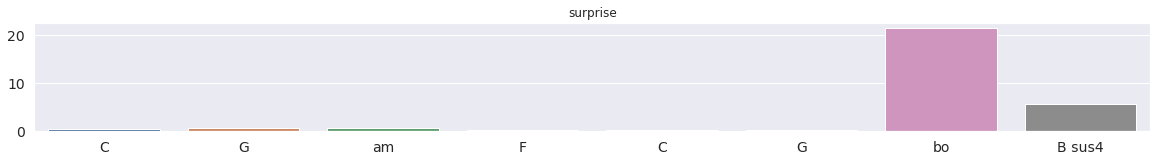

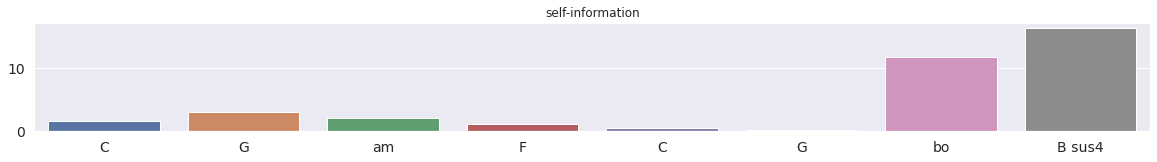

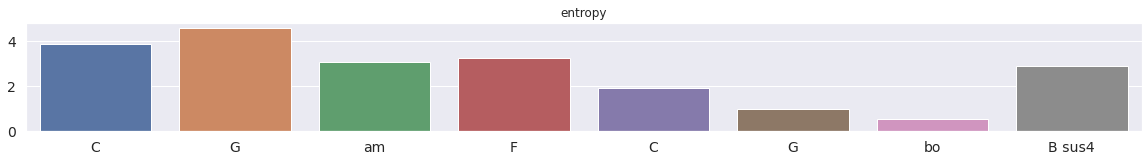

In [78]:
test_chords=[BOS_TOKEN]+["C","G","am","F"]+["C","G","bo","B sus4"]
p,i,e,s=compute_pies(test_chords)

plot_words(test_chords[1:],s,"surprise")
plot_words(test_chords[1:],i,"self-information")
plot_words(test_chords[1:],e,"entropy")

play_audio(synthesize_chords(test_chords))

In [47]:
# load an example midi file and take first 10 notes as context

context = [BOS_TOKEN]

x = torch.tensor([trn_ds.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
p = torch.softmax(model(x)[0],axis=-1).detach().cpu().numpy()

print(p.shape)

max_idx=np.argsort(-p[:,-1,:])[0][:10]

print(max_idx.shape)

for m in max_idx:
  print(trn_ds.itos[m])
  print(p[:,-1,m])
  print("  ")

#play_audio(synthesize_chords(completion))

(1, 1, 691)
(10,)
C
[0.28359345]
  
cm
[0.23642762]
  
F
[0.07563786]
  
am
[0.0505636]
  
Ab
[0.05032834]
  
G
[0.02583905]
  
cm7
[0.02537695]
  
dm
[0.01807046]
  
Abmaj7
[0.01576707]
  
Cmaj7
[0.01471]
  


In [44]:
for s in sequences[:40]:
  print(s)

['<BOS>', 'C', 'dm7', 'F', 'G', 'C', 'dm7', 'F', 'G', 'C', 'dm7', 'F', 'G', 'F', 'G', 'dm7', 'C | E', 'F', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>']
['<BOS>', 'C', 'Bb', 'C', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>']
['<BOS>', 'cm', 'fm', 'G', 'cm', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>']
['<BOS>', 'G', 'F', 'C', 'G', 'F', 'C', 'G', 'F', 'C', 'C | G', 'G', 'C', 'C | G', 'G', 'C', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<EOS>', '<E